In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames
pd.options.display.float_format = '{:.2f}'.format # affiche les nombres à virgule flottante avec 2 décimales

# Import

In [2]:
# lecture des données de circulation :
df_raw = pd.read_parquet("../data/2-clean/slo_2024.parquet")

In [3]:
# lecture des données sur les gares :
gares = pd.read_parquet("../data/2-clean/gares-de-voyageurs.parquet")

# Merge

In [128]:
df = df_raw.copy()

# Récupère les infos de la gare d'origine
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']], 
             left_on='code_ci_origine',
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_origine', 
        'code_departement': 'code_dpt_origine', 
        'nom_departement': 'nom_dpt_origine', 
        'region': 'region_origine'})
    .drop(columns=['code_ci']))

# Récupère les infos de la gare de destination
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']],
             left_on='code_ci_destination', 
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_destination',
        'code_departement': 'code_dpt_destination',
        'nom_departement': 'nom_dpt_destination',
        'region': 'region_destination'})
    .drop(columns=['code_ci'])
)

# Analyse

In [273]:
df['num_semaine'] = df['date_circ'].dt.isocalendar().week # TODO à mettre dans le script d'ingestion

In [129]:
# Ajout de colonnes simplifiées : True si le train a plus de n minutes de retard a
for t in [5, 10, 15, 30, 60]:
    # df[f"ret_depart_{t}min"] = df["ret_depart_obs_min"] >= t  # pas utilisé
    df[f"ret_arrivee_{t}min"] = df["ret_arrivee_obs_min"] >= t

In [126]:
# top 10 des plus grands retards à l'arrivée : 
df.sort_values(by='ret_arrivee_obs_min', ascending=False).head() 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ch_origine,code_ci_destination,lib_ci_destination,code_ch_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,ret_depart_5min,ret_arrivee_5min,ret_depart_10min,ret_arrivee_10min,ret_depart_15min,ret_arrivee_15min,ret_depart_30min,ret_arrivee_30min,ret_depart_60min,ret_arrivee_60min
99400,85272125,2024-05-24,5224,286005,Lille-Flandres,BV,481002,Nantes,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-05-23 09:36:00,2024-05-24 09:35:46,2024-05-24 09:35:46,2024-05-23 14:44:00,2024-05-24 14:41:04,2024-05-24 14:41:04,704196,86386.00,1439.77,86224.00,1437.07,[60+],308.00,>3h,305.30,5,4,9,14,A,59,Nord,Hauts-de-France,A,44,Loire-Atlantique,Pays de la Loire,True,True,True,True,True,True,True,True,True,True
63797,84338849,2024-04-03,8537,391003,Paris-Montparnasse,BV,677005,Hendaye,00,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2024-04-03 10:04:00,2024-04-03 10:03:20,2024-04-03 10:03:20,2024-04-03 14:47:00,2024-04-04 02:27:00,2024-04-04 02:27:00,769999,-40.00,-0.67,42000.00,700.00,[60+],283.00,>3h,983.67,4,2,10,2,A,75,Paris,Ile-de-France,B,64,Pyrénées-Atlantiques,Nouvelle-Aquitaine,False,True,False,True,False,True,False,True,False,True
159272,86872362,2024-08-17,4080,481002,Nantes,BV,484006,Angers-St-Laud,BV,OSLO,"GL Inter-Villes - Train classique, VL>= 160 km/h","GL Inter-Villes - Train classique, VL>= 160 km/h",22200,22200,2024-08-17 06:40:00,2024-08-17 06:39:37,2024-08-17 06:39:37,2024-08-17 07:22:00,2024-08-17 18:15:42,2024-08-17 18:15:42,87422,-23.00,-0.38,39222.00,653.70,[60+],42.00,<1h30,696.08,8,5,6,18,A,44,Loire-Atlantique,Pays de la Loire,A,49,Maine-et-Loire,Pays de la Loire,False,True,False,True,False,True,False,True,False,True
144775,86491551,2024-07-26,7668,286542,Tourcoing,BV,581009,Bordeaux-St-Jean,BV,SNCF-VOYAGES,"TAGV haute capacité Nord, à charge","TAGV haute capacité Nord, à charge",TGVDAS,TGVDAS,2024-07-26 06:02:00,2024-07-26 10:42:00,2024-07-26 10:42:00,2024-07-26 11:02:00,2024-07-26 21:16:13,2024-07-26 21:16:13,918736,16800.00,280.00,36853.00,614.22,[60+],300.00,>3h,634.22,7,4,10,21,A,59,Nord,Hauts-de-France,A,33,Gironde,Nouvelle-Aquitaine,True,True,True,True,True,True,True,True,True,True
144553,86489397,2024-07-26,5260,581009,Bordeaux-St-Jean,BV,286005,Lille-Flandres,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-07-26 05:58:00,2024-07-26 05:58:01,2024-07-26 05:58:01,2024-07-26 10:42:00,2024-07-26 20:31:13,2024-07-26 20:31:13,888008,1.00,0.02,35353.00,589.22,[60+],284.00,>3h,873.20,7,4,5,20,A,33,Gironde,Nouvelle-Aquitaine,A,59,Nord,Hauts-de-France,False,True,False,True,False,True,False,True,False,True


In [7]:
# on va ignorer le retard > 1400 minutes, c'est aberrant et ça casse tous les graphiques après
df = df[df['ret_arrivee_obs_min'] <= 1400]

In [95]:
# top 10 des plus grandes avances au départ
df.sort_values(by='ret_depart_obs_min', ascending=True).head()

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ch_origine,code_ci_destination,lib_ci_destination,code_ch_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min,ret_arrivee_30min,ret_arrivee_60min
29742,83385299,2024-02-11,6124,751081,Marseille-Blancarde,BV,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-11 15:46:00,2024-02-10 15:32:28,2024-02-10 15:32:28,2024-02-11 19:23:00,2024-02-11 19:26:51,2024-02-11 19:26:51,753375,-87212.00,-1453.53,231.00,3.85,"[0,5[",217.00,>3h,1674.38,2,6,15,19,B,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,A,75,Paris,Ile-de-France,False,False,False,False,False
67789,84446252,2024-04-08,6689,722439,Givors-Canal,BV,726000,St-Étienne-Châteaucreux,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-04-08 21:22:30,2024-04-08 06:35:59,2024-04-08 06:35:59,2024-04-08 21:48:00,2024-04-08 21:48:16,2024-04-08 21:48:16,37127,-53191.00,-886.52,16.00,0.27,"[0,5[",25.50,<1h30,912.28,4,0,6,21,C,69,Rhône,Auvergne-Rhône-Alpes,B,42,Loire,Auvergne-Rhône-Alpes,False,False,False,False,False
97350,85213756,2024-05-21,7106,343004,Valenciennes,BV,271007,Paris-Nord,BV,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGV-D,TGV-D,2024-05-21 06:57:00,2024-05-20 20:16:49,2024-05-20 20:16:49,2024-05-21 08:49:00,2024-05-21 08:50:24,2024-05-21 08:50:24,239453,-38411.00,-640.18,84.00,1.40,"[0,5[",112.00,1h30-3h,753.58,5,1,20,8,B,59,Nord,Hauts-de-France,A,75,Paris,Ile-de-France,False,False,False,False,False
22249,83177938,2024-02-03,6250,688887,Montpellier (CNM),BV,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-02-03 07:52:00,2024-02-02 22:40:27,2024-02-02 22:40:27,2024-02-03 11:04:00,2024-02-03 11:20:57,2024-02-03 11:20:57,731079,-33093.00,-551.55,1017.00,16.95,"[15,30[",192.00,>3h,760.50,2,5,22,11,A,34,Hérault,Occitanie,A,75,Paris,Ile-de-France,True,True,True,False,False
101138,85319775,2024-05-26,6180,756056,Nice-Ville,00,686006,Paris-Gare-de-Lyon,BV,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-05-26 16:58:00,2024-05-26 07:57:55,2024-05-26 07:57:55,2024-05-26 22:38:00,2024-05-26 23:13:59,2024-05-26 23:13:59,971692,-32405.00,-540.08,2159.00,35.98,"[30,60[",340.00,>3h,916.07,5,6,7,23,A,06,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,A,75,Paris,Ile-de-France,True,True,True,True,False


Text(0.5, 1.0, "Répartition des retards à l'arrivée selon la durée du trajet")

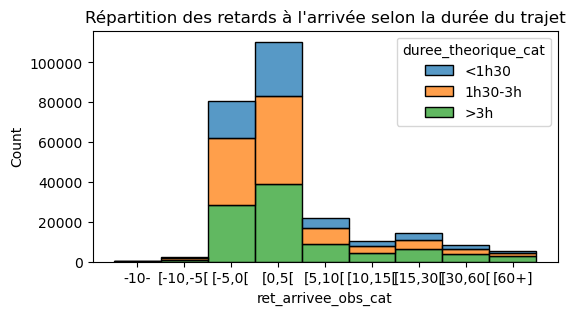

In [9]:
# Répartition des retards à l'arrivée selon la durée du trajet
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="ret_arrivee_obs_cat", hue="duree_theorique_cat", multiple="stack", stat="count")
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")

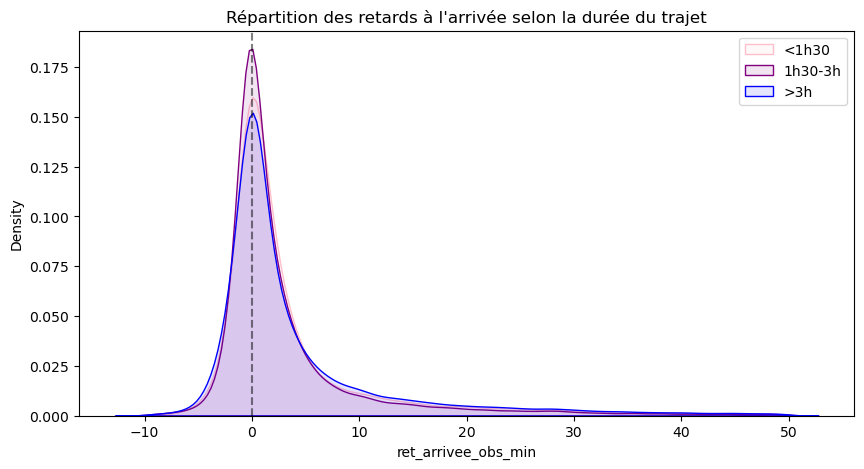

In [10]:
# Répartition des retards à l'arrivée selon la durée du Trajet
plt.figure(figsize=(10,5))
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '<1h30')], x='ret_arrivee_obs_min', fill=True, color='pink', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '1h30-3h')], x='ret_arrivee_obs_min', fill=True, color='purple', alpha=0.1)
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50) & (df['duree_theorique_cat'] == '>3h')], x='ret_arrivee_obs_min', fill=True, color='blue', alpha=0.1)
plt.legend(['<1h30', '1h30-3h', '>3h'])
plt.title("Répartition des retards à l'arrivée selon la durée du trajet")
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# constat : les trains de 3 h sont légèrement plus en retard (autant au départ qu'à l'arrivée), mais c'est subtil

Text(0.5, 1.0, "Répartition des retards à l'arrivée (entre -10 min et +50 min)")

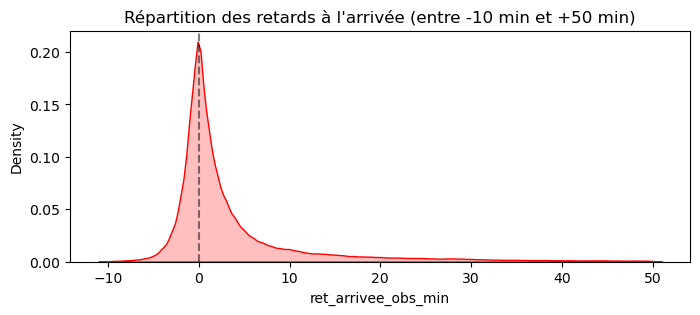

In [11]:
# Réparatition des retards à l'arrivée
plt.figure(figsize=(8,3))
sns.kdeplot(data=df[(df['ret_arrivee_obs_min'] >= -10) & (df['ret_arrivee_obs_min'] <= 50)]['ret_arrivee_obs_min'], fill=True, bw_adjust=0.5, color='r')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title("Répartition des retards à l'arrivée (entre -10 min et +50 min)")

Text(0.5, 1.0, 'Répartition des retards au DEPART (entre -10 min et +50 min)')

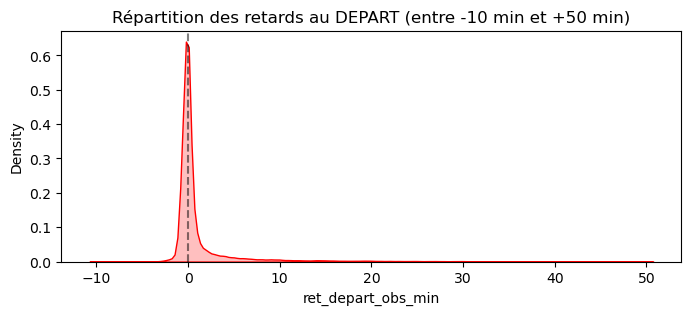

In [12]:
# Réparatition des retards au départ
plt.figure(figsize=(8,3))
sns.kdeplot(df[(df['ret_depart_obs_min'] >= -10) & (df['ret_depart_obs_min'] <= 50)]['ret_depart_obs_min'], fill=True, bw_adjust=0.5, color='r')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title("Répartition des retards au DEPART (entre -10 min et +50 min)")
# constat : les trains sont nettement plus ponctuels au départ qu'à l'arrivée (cloche plus resserée et pic à 0.6 sur x=0, contre seulement 0.2 à l'arrivée)

In [13]:
# calcul de la corrélation entre duree_theorique_min et ret_arrivee_obs_min
df[['duree_theorique_min', 'ret_arrivee_obs_min']].corr()
# constat : aucune corrélation entre durée du trajet et retard

,duree_theorique_min,ret_arrivee_obs_min
duree_theorique_min,1.00,0.06
ret_arrivee_obs_min,0.06,1.00


<Axes: xlabel='duree_theorique_min', ylabel='ret_arrivee_obs_min'>

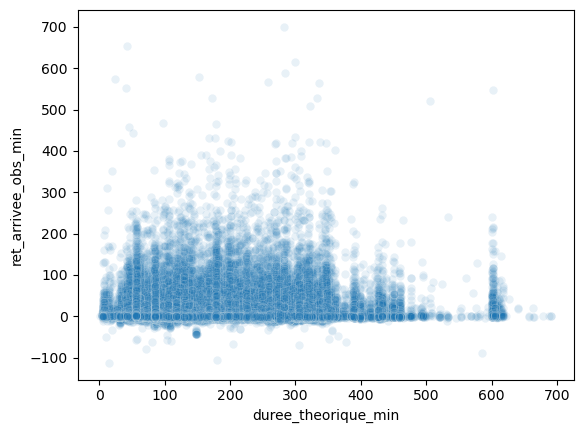

In [14]:
# Répartition des retards selon la durée du trajet (scatterplot)
sns.scatterplot(data=df, x="duree_theorique_min", y="ret_arrivee_obs_min", alpha=0.1)
# constat : aucune corrélation entre durée du trajet et retard

Text(0.5, 1.0, "Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

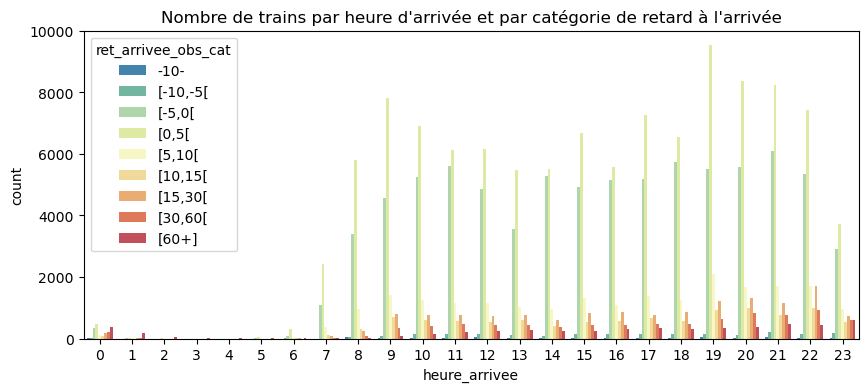

In [15]:
# Affiche le nombre de ret_arrivee_obs_cat par heure_arrivee
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_obs_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='heure_arrivee', hue='ret_arrivee_obs_cat', palette=palette)
plt.title("Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée")

Text(0.5, 1.0, "Nombre de trains par mois et par catégorie de retard à l'arrivée")

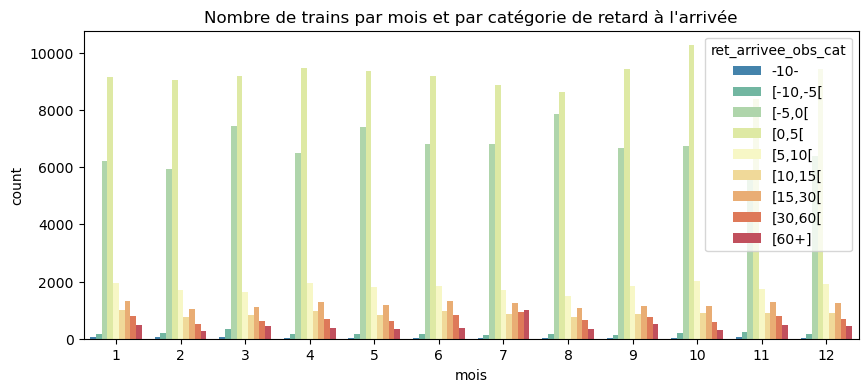

In [16]:
# Affiche le nombre de ret_arrivee_obs_cat par mois
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_obs_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='mois', hue='ret_arrivee_obs_cat', palette=palette)
plt.title("Nombre de trains par mois et par catégorie de retard à l'arrivée")

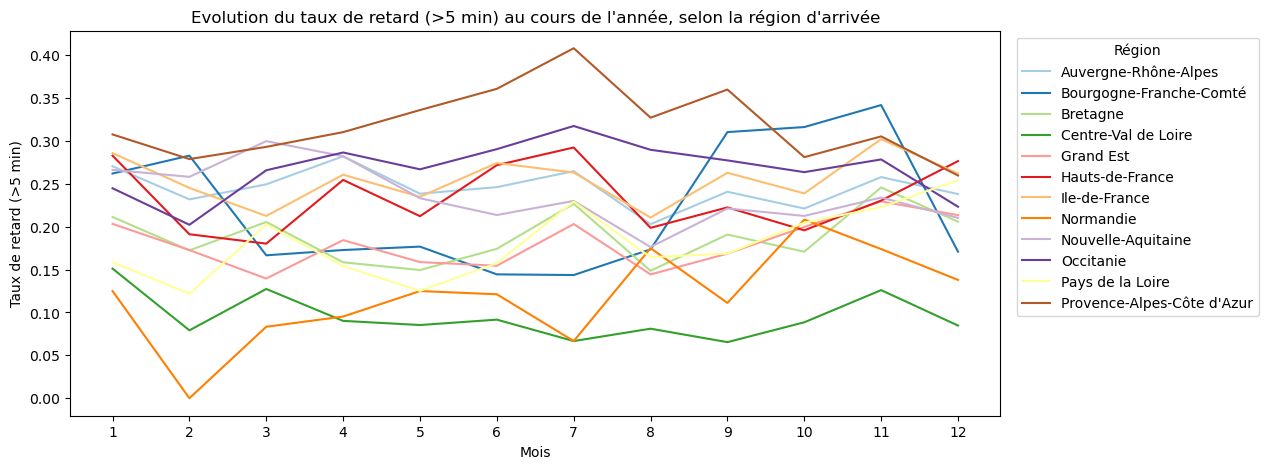

In [130]:
# Evolution des retards à l'arrivée au cours de l'année, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['mois', 'region_destination']).agg(
    taux_retard = ('ret_arrivee_5min', 'mean'),
    region = ('region_destination', 'first')
)
retard_5min_mensuel.reset_index(inplace=True)
retard_5min_mensuel['mois'] = retard_5min_mensuel['mois'].astype(str)
plt.figure(figsize=(12, 5))
sns.lineplot(data=retard_5min_mensuel, x='mois', y='taux_retard', hue='region', palette='Paired')
plt.title("Evolution du taux de retard (>5 min) au cours de l'année, selon la région d'arrivée")
plt.xlabel("Mois")
plt.ylabel("Taux de retard (>5 min)")
plt.legend(title='Région', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()


In [147]:
# Taux de retard à l'arrivée, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['region_destination']).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_5min_mensuel.sort_values(by='taux_retard_15min', ascending=False).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
region_destination,,,,,,,,
Provence-Alpes-Côte d'Azur,9.491596,1.900000,0.320534,0.215991,0.163913,0.081311,0.033299,15496
Occitanie,6.927760,0.166667,0.268169,0.186045,0.142455,0.073092,0.029170,12067
Hauts-de-France,6.203658,0.933333,0.234049,0.162644,0.119956,0.059508,0.021487,35138
Ile-de-France,6.464102,1.183333,0.254142,0.159702,0.113890,0.054688,0.020725,97225
Auvergne-Rhône-Alpes,6.043017,1.116667,0.245436,0.147396,0.106338,0.049119,0.016044,25306
Normandie,2.631004,-2.000000,0.121118,0.105590,0.102484,0.049689,0.015528,322
Bourgogne-Franche-Comté,5.787961,0.900000,0.213398,0.129660,0.101567,0.046461,0.017288,1851
Pays de la Loire,5.656788,0.000000,0.180462,0.125629,0.096044,0.051709,0.024206,11526
Nouvelle-Aquitaine,5.641560,0.533333,0.235862,0.136307,0.092191,0.043907,0.020286,14394


In [228]:
# Taux de retard_5min par type de trajet (lib_tct_arrivee)
retard_par_libtct = df.groupby('lib_tct_arrivee').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_par_libtct.sort_values(by='taux_retard_5min', ascending=False)

,lib_tct_arrivee,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
20,"Voyageurs internationaux - VL<160km/h non TAGV (hors spéciaux), à charge",25.16,5.10,0.51,0.44,0.39,0.27,0.17,190
16,"TAGV international France Angleterre, à charge",7.29,2.17,0.34,0.21,0.15,0.06,0.02,928
17,"TAGV spéciaux nationaux (pèlerins et autres), à charge",10.28,2.00,0.33,0.23,0.19,0.13,0.07,271
8,"TAGV International France Espagne, à charge",8.34,1.58,0.33,0.22,0.16,0.07,0.03,1588
9,"TAGV International France Italie, à charge",7.31,2.30,0.31,0.17,0.10,0.05,0.02,1009
11,"TAGV International France-Espagne, à charge",7.74,1.67,0.30,0.18,0.12,0.07,0.02,1421
14,"TAGV haute capacité Nord, à charge",8.92,1.23,0.30,0.21,0.16,0.08,0.03,5668
7,"TAGV International France Allemagne, à charge",6.91,1.28,0.29,0.19,0.13,0.06,0.02,7790
2,TAGV (Train A Grande Vitesse - à charge),7.02,1.18,0.28,0.20,0.15,0.07,0.02,33934
15,"TAGV haute capacité Sud-Est, à charge",7.87,1.13,0.27,0.18,0.14,0.07,0.03,6467


In [118]:
# Taux de retard TAGV par axe majeur DEPUIS PARIS
TAGV_depuis_paris = df[df['lib_ci_origine'].str.startswith("Paris") & df['lib_tct_arrivee'].str.startswith("TAGV")].copy()
TAGV_depuis_paris['lib_tct_arrivee'].value_counts()
TAGV_depuis_paris['Axe'] = TAGV_depuis_paris['lib_tct_arrivee'].map({
    'TAGV - Sud-Est, à charge': 'Sud-Est',
    'TAGV - Atlantique, à charge': 'Atlantique',
    'TAGV (Train A Grande Vitesse - à charge)': 'Inconnu',
    'TAGV - Est, à charge': 'Est',
    'TAGV - Nord, à charge': 'Nord',
    'TAGV International France Suisse, à charge': 'Suisse',
    'TAGV, axe Bretagne, à charge': 'Bretagne',
    'TAGV International France Allemagne, à charge': 'Allemagne',
    'TAGV haute capacité Sud-Est, à charge': 'Sud-Est (HC)',
    'TAGV haute capacité Atlantique, à charge': 'Atlantique (HC)',
    'TAGV International France Espagne, à charge': 'Espagne',
    'TAGV haute capacité Est, à charge': 'Est (HC)',
    'TAGV International France Italie, à charge': 'Italie',
    'TAGV international France Angleterre, à charge': 'Angleterre'
})
# tous les trains d'axe 'inconnu' sont en fait opérés par Thalys ou Trenitalia
# on va leur faire des catégories plus précises en fonction de leur département de destination
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Hauts-de-France'), 
    'Axe'
] = 'Nord (Thalys)'
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Auvergne-Rhône-Alpes'), 
    'Axe'
] = 'Sud-Est (Trenitalia)'

retard_par_axe = TAGV_depuis_paris.groupby('Axe').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_par_axe.reset_index(inplace=True)
retard_par_axe.sort_values(by='taux_retard_15min', ascending=False, inplace=True)
retard_par_axe.style.background_gradient(cmap='coolwarm')

# constats :
# - trains haute capacité (HC) sont moins ponctuels que trains classiques
# - lignes internationales plus en retard que lignes nationales : Angleterre, Espagne, Italie...
# - à l'excpetion de la Suisse et Allemagne
# - axes les plus ponctuels : Trenitalia, Est, Nord, 

,Axe,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
1,Angleterre,8.734831,2.408333,0.363281,0.238281,0.175781,0.093750,0.023438,256
5,Espagne,7.700719,1.125000,0.319797,0.223350,0.167513,0.067259,0.026650,788
12,Sud-Est (HC),8.103272,1.166667,0.276173,0.186393,0.139795,0.074868,0.025784,3219
3,Atlantique (HC),7.556236,0.000000,0.235466,0.163040,0.127314,0.076648,0.042546,3079
14,Suisse,6.474694,1.083333,0.232376,0.156977,0.121185,0.053961,0.017805,5504
10,Nord (Thalys),5.708909,0.583333,0.199094,0.148338,0.119542,0.065026,0.022644,11703
7,Est (HC),5.147599,-0.366667,0.170629,0.127273,0.110490,0.067133,0.026573,715
11,Sud-Est,6.040857,0.883333,0.232480,0.147262,0.108160,0.053360,0.019273,21533
8,Italie,7.913400,3.000000,0.306818,0.164773,0.105114,0.051136,0.014205,352
4,Bretagne,5.667675,0.000000,0.186506,0.124079,0.099263,0.052927,0.022877,5158


In [ ]:
# gares d'arrivée les plus populaires
df['lib_ci_destination'].value_counts()

lib_ci_destination
Paris-Gare-de-Lyon    32805
Paris-Montparnasse    26759
Paris-Nord            19262
Paris-Est             15149
Wannehain             13027
                      ...  
Troyes                    1
St-Claude                 1
Rives                     1
Albi-Ville                1
Belfort                   1
Name: count, Length: 228, dtype: Int64

In [ ]:
# constat : 50% des trajets ne sont empruntés que 10 fois ou moins
df['num_marche'].value_counts().describe()

count   2461.00
mean     103.21
std      138.51
min        1.00
25%        1.00
50%       10.00
75%      246.00
max      366.00
Name: count, dtype: Float64

In [96]:
# Taux de retard en fonction du trajet effectué (pour les trajets num_marche ayant au moins n occurences)
n = 10
# conserve uniquement les marches ayant un minimum de n circulations (n occurences dans le tableau)
marches_n_circulations = df['num_marche'].value_counts()[lambda x: x >= n].index
retard_num_marche = df[df['num_marche'].isin(marches_n_circulations)].groupby('num_marche').agg(
    origine = ('lib_ci_origine', 'first'),
    destination = ('lib_ci_destination', 'first'),
    retard_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nombre_circulations = ('id_circ', 'count')
).sort_values(by='retard_median', ascending=False)
retard_num_marche.head(10).style.background_gradient(cmap='coolwarm')

,origine,destination,retard_moyen,retard_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nombre_circulations
num_marche,,,,,,,,
26823,Lyon-Part-Dieu,Montpellier-St-Roch,45.680769,49.050000,1.000000,0.923077,0.923077,13
26986,Chambéry-Challes-les-Eaux,Paris-Gare-de-Lyon,47.758824,35.900000,0.764706,0.764706,0.764706,17
26514,Bordeaux-St-Jean,Paris-Montparnasse,48.619444,31.025000,0.583333,0.583333,0.583333,12
26864,Lyon-Part-Dieu,Marne-la-Vallée-Chessy,34.804762,27.558333,0.785714,0.642857,0.571429,14
26560,Dax,Paris-Montparnasse,46.864583,23.650000,0.625000,0.562500,0.500000,16
9362,Wannehain,Paris-Nord,35.692157,23.450000,0.764706,0.647059,0.647059,17
26702,Rennes,Paris-Montparnasse,30.992063,21.883333,0.714286,0.619048,0.571429,21
9468,Stiring-Wendel,Paris-Est,37.400758,19.975000,0.647727,0.613636,0.568182,88
26320,Arras,Paris-Nord,44.800000,19.591667,0.600000,0.600000,0.600000,10


In [113]:
# Taux de retard parmi les n gares d'arrivée les plus courantes -> #TODO utiliser plutot le segment DRG issu de "gares"
n = 50
top_n_gares = df['lib_ci_destination'].value_counts().head(n).index
retard_5min_gare = df[df['lib_ci_destination'].isin(top_n_gares)].groupby('lib_ci_destination').agg(
    retard_median = ('ret_arrivee_obs_min', 'median'),
    retard_moyen = ('ret_arrivee_obs_min', 'mean'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nombre_circulations = ('id_circ', 'count')
    ).sort_values(by='taux_retard_5min', ascending=False)
retard_5min_gare.head(10).style.background_gradient(cmap='coolwarm')

,retard_median,retard_moyen,taux_retard_5min,taux_retard_10min,taux_retard_15min,nombre_circulations
lib_ci_destination,,,,,,
Nice-Ville,3.291667,13.225772,0.410664,0.276661,0.212172,3582
Lyon-Part-Dieu,2.566667,8.289871,0.328217,0.185013,0.132700,4951
Paris-Nord,2.083333,7.890378,0.324836,0.218928,0.157305,19262
Grenoble,2.000000,7.565985,0.318091,0.195347,0.141195,2493
Montpellier-St-Roch,0.666667,8.538134,0.305556,0.224034,0.176932,1656
Montpellier (CNM),1.183333,7.517482,0.304018,0.190675,0.137604,2638
Marseille-St-Charles,1.666667,8.592354,0.302925,0.202652,0.153935,9504
St-Étienne-Châteaucreux,1.541667,5.737628,0.281199,0.136953,0.086710,1234
Bordeaux-St-Jean,1.350000,6.771718,0.272837,0.159341,0.109547,5824


In [205]:
# Taux de retard en fonction de la longueur du trajet (distance_totale)
# sns.scatterplot(data=df, x='distance_totale', y='ret_arrivee_obs_min', alpha=0.1)
# plt.title("Retard à l'arrivée en fonction de la longueur du trajet")
# à première vue, pas de corrélation nette entre distance et retard.
# néanmoins, graphique peu lisible car trop de points, on ne réalise pas bien la densité.
# voir taux de retard selon la distance plus bas

Text(500, 450, 'f(x)=x')

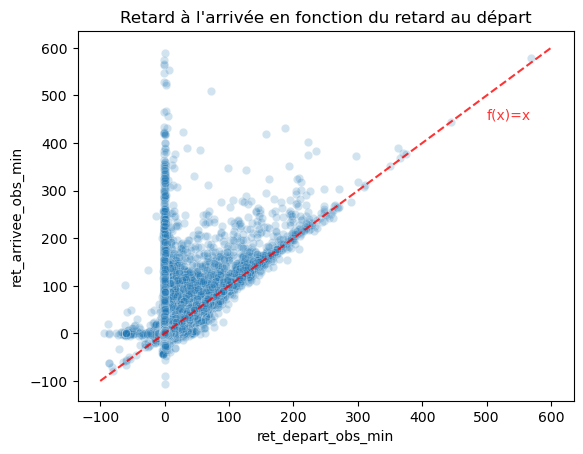

In [212]:
# Retard à l'arrivée en fonction du retard au départ
sns.scatterplot(data=df[(df['ret_depart_obs_min'] > -100) & (df['ret_arrivee_obs_min'] < 600)], x='ret_depart_obs_min', y='ret_arrivee_obs_min', alpha=0.2)
# constat : 
# - ligne verticale à x=0 : trains l'heure au départ, mais avec du retard à l'arrivée 
# - droite oblique : les trains qui ont conservé leur retard initial.
# - f(x)<x (sous la droite rouge) : trains qui ont récupéré un petit peu de leur retard initial 
# - f(x)>x (au dessus de la droite): les trains qui ont pris du retard au cous du trajet, en plus de leur retard initial.

# trace f(x) = x
plt.plot([-100, 600], [-100, 600], color='red', linestyle='--', alpha=0.8)
plt.title("Retard à l'arrivée en fonction du retard au départ")
plt.text(500, 450, "f(x)=x", color='red', alpha=0.8)

In [103]:
# Taux de retard selon le département de destination
retard_par_departement = df.groupby('code_dpt_destination').agg(
    nom_departement = ('nom_dpt_destination', 'first'),
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_departement.head(10).style.background_gradient(cmap='coolwarm')

,nom_departement,retard_arrivee_moyen,retard_arrivee_median,nb_circulations
code_dpt_destination,,,,
01,Ain,7.487555,1.500000,2732
02,Aisne,-0.850000,-0.850000,1
03,Allier,2.842105,2.000000,19
05,Hautes-Alpes,67.000000,67.000000,2
06,Alpes-Maritimes,13.382395,3.316667,3589
08,Ardennes,3.872508,0.166667,739
10,Aube,2.500000,3.000000,4
11,Aude,48.301667,2.441667,10
13,Bouches-du-Rhône,8.567809,1.700000,10210


In [99]:
# Taux de retard par région d'arrivée
retard_par_region = df.groupby('region_destination').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    nb_circulations = ('id_circ', 'count')
)
retard_par_region.sort_values(by='taux_retard_15min', ascending=False).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,nb_circulations
region_destination,,,,,,
Provence-Alpes-Côte d'Azur,9.491596,1.900000,0.320534,0.215991,0.163913,15496
Occitanie,6.927760,0.166667,0.268169,0.186045,0.142455,12067
Hauts-de-France,6.203658,0.933333,0.234049,0.162644,0.119956,35138
Ile-de-France,6.464102,1.183333,0.254142,0.159702,0.113890,97225
Auvergne-Rhône-Alpes,6.043017,1.116667,0.245436,0.147396,0.106338,25306
Normandie,2.631004,-2.000000,0.121118,0.105590,0.102484,322
Bourgogne-Franche-Comté,5.787961,0.900000,0.213398,0.129660,0.101567,1851
Pays de la Loire,5.532587,0.000000,0.180390,0.125553,0.095965,11525
Nouvelle-Aquitaine,5.641560,0.533333,0.235862,0.136307,0.092191,14394


In [ ]:
# encodage des variables catégorielles
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['ret_depart_obs_sec', 'ret_arrivee_obs_sec', 'ret_arrivee_obs_cat']) 
for col in df_encoded.select_dtypes(include=['object','string','category']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

In [ ]:
# calcul des corrélations
df_encoded_corr = df_encoded.corr()

Text(0.5, 1.0, 'Heatmap de corrélation entre le variables')

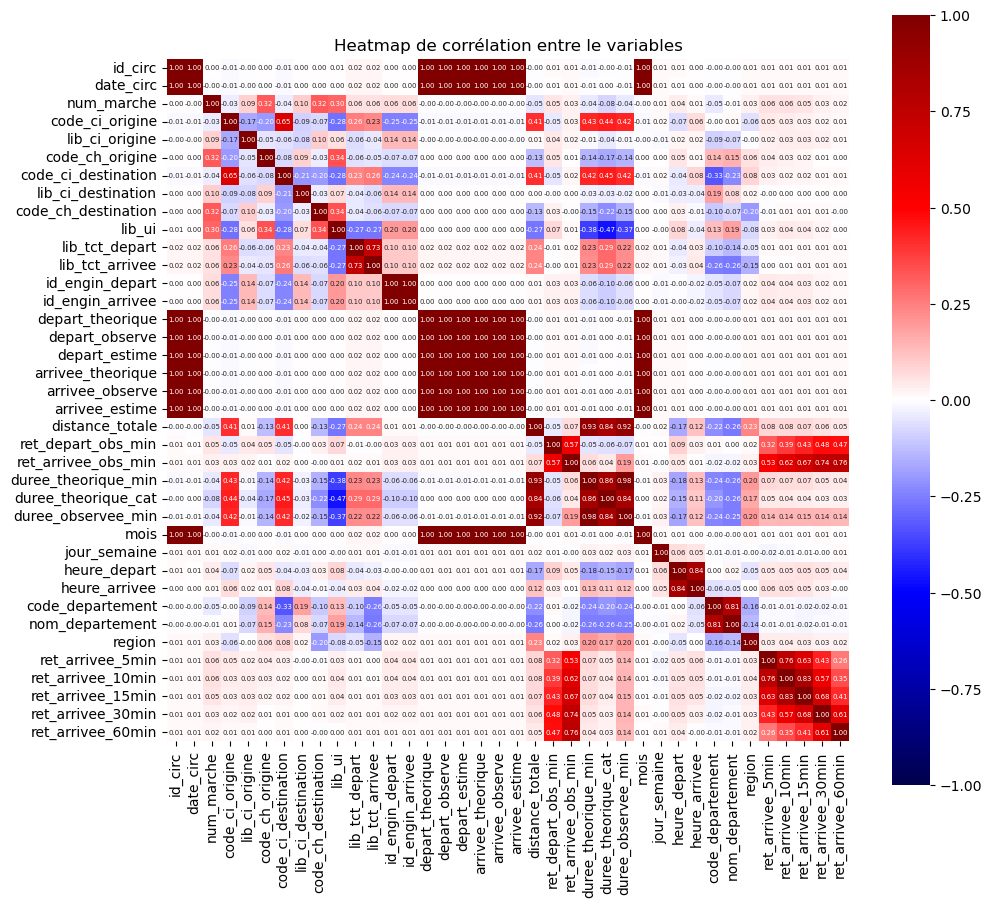

In [ ]:
# heatmap de corrélation
plt.figure(figsize=(11, 10))
plt.gca().set_aspect('equal', adjustable='box')
sns.heatmap(df_encoded_corr, annot=True, fmt=".2f", cmap="seismic", vmax=1, vmin=-1, annot_kws={"size": 5})
plt.title("Heatmap de corrélation entre le variables")

# constat : le retard à l'arrivée n'a aucune corrélation significative avec des variables comme la région (0.03), 
# le num_marche (0.05), id_engin (0.04), lib_ui (0.04), etc.

# la distance totale (0.07), la durée théorique (0.07), et la durée observée (0.14) on également une corrélation assez faible.

# la seule corrélation notable serait le retard au départ (environ 0.6 selon la métrique utilisée : retard moyen, taux de retard à 5min, etc).

# Notons que, si l'objectif est de prédire le retard d'un train, le retard au départ et la durée observée du trajet 
# ne sont pas connus à l'avance et donc pas utilisables comme variables prédictives.

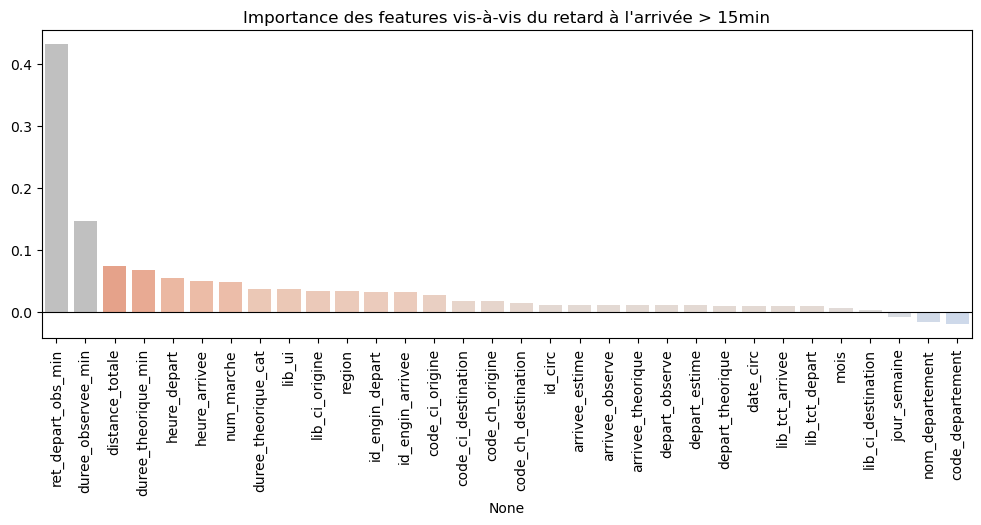

In [ ]:
# Importance des features vis-à-vis du retard à l'arrivée > 15min

corr_series = df_encoded_corr.loc["ret_arrivee_15min"].sort_values(ascending=False)

# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_arrivee_60min", "ret_arrivee_30min", "ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee_obs_min"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# on passe en gris les colonnes non connues à l'avance : 
unknown_cols = ["ret_depart_obs_min", "duree_observee_min"]
for i, col in enumerate(corr_series.index):
    if col in unknown_cols:
        colors[i] = ("#C0C0C0")

plt.figure(figsize=(12, 4))
sns.barplot(
    x=corr_series.index,
    y=corr_series.values,
    hue=corr_series.index,
    palette=colors
)
plt.xticks(rotation=90)
plt.title("Importance des features vis-à-vis du retard à l'arrivée > 15min")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.show()


In [149]:
df.head(3)

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ch_origine,code_ci_destination,lib_ci_destination,code_ch_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min,ret_arrivee_30min,ret_arrivee_60min
0,82518798,2024-01-01,2352,182014,Colmar,BV,212027,Strasbourg-Ville,BV,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGV2N2,TGV2N2,2024-01-01 07:41:00,2024-01-01 07:41:26,2024-01-01 07:41:26,2024-01-01 08:16:00,2024-01-01 08:15:14,2024-01-01 08:15:14,65817,26.00,0.43,-46.00,-0.77,"[-5,0[",35.00,<1h30,33.80,1,0,7,8,B,68,Haut-Rhin,Grand Est,A,67,Bas-Rhin,Grand Est,False,False,False,False,False
1,82518819,2024-01-01,2407,113001,Paris-Est,00,212027,Strasbourg-Ville,BV,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 07:58:00,2024-01-01 07:58:06,2024-01-01 07:58:06,2024-01-01 09:59:00,2024-01-01 09:58:40,2024-01-01 09:58:40,439423,6.00,0.10,-20.00,-0.33,"[-5,0[",121.00,1h30-3h,120.57,1,0,7,9,A,75,Paris,Ile-de-France,A,67,Bas-Rhin,Grand Est,False,False,False,False,False
2,82518825,2024-01-01,2535,141002,Nancy-Ville,BV,113001,Paris-Est,00,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:11:00,2024-01-01 08:11:01,2024-01-01 08:11:01,2024-01-01 09:48:30,2024-01-01 09:48:23,2024-01-01 09:48:23,327284,1.00,0.02,-7.00,-0.12,"[-5,0[",97.50,1h30-3h,97.37,1,0,8,9,A,54,Meurthe-et-Moselle,Grand Est,A,75,Paris,Ile-de-France,False,False,False,False,False


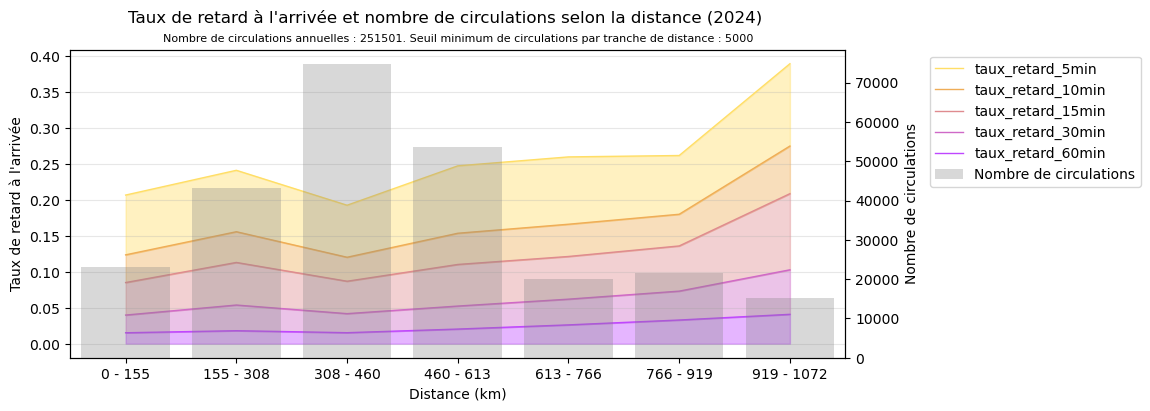

In [204]:
# Taux de ratrd selon la distance
df_copy = df.copy()
# Répartition des distances totales
# df_copy['distance_totale'].plot(kind='hist', bins=20)

seuil_trajets = 5000 # nombre minimal de trajets pour considérer la donnée comme pertinente

# Ajout d'une variable catégorielle pour la distance
df_copy['distance_totale_cat'] = pd.cut(df_copy['distance_totale'], bins=10)

# Probabilité d'être en retard à l'arrivée selon la distance
stats = df_copy.groupby(["distance_totale_cat"], observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

stats = stats.reset_index()

# élimine les tranches de distance avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets]

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la distance (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche de distance : {seuil_trajets}", fontsize=8)
plt.xlabel("Distance (km)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = [f"{int(interval.left/1000)} - {int(interval.right/1000)}" for interval in stats["distance_totale_cat"]]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : le taux de retard semble légèrement augmenter avec la distance

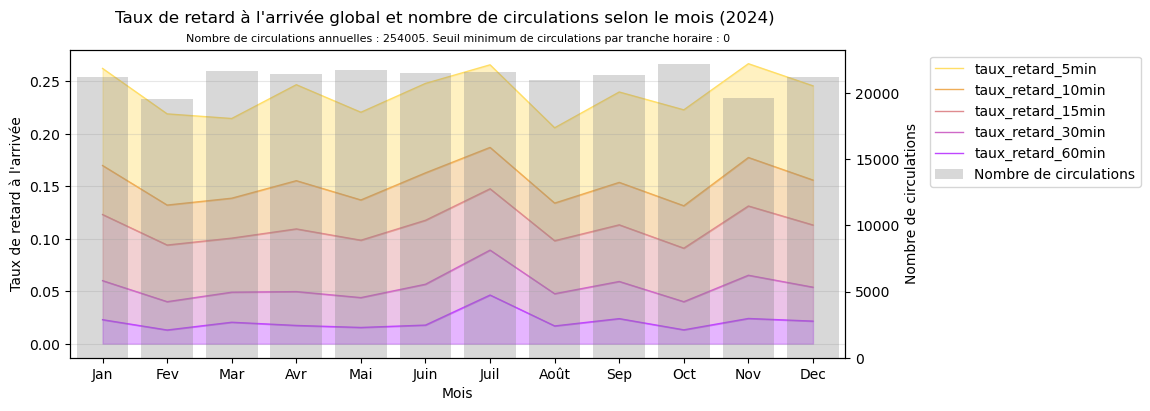

In [ ]:
### Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le mois
stats = df.groupby(["mois"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le mois comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le mois (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Mois")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

# constat : juillet, seul mois de l'année où les très gros retards (>60 minutes) montent à 5% (contre 2-3% le reste de l'année)

plt.show()

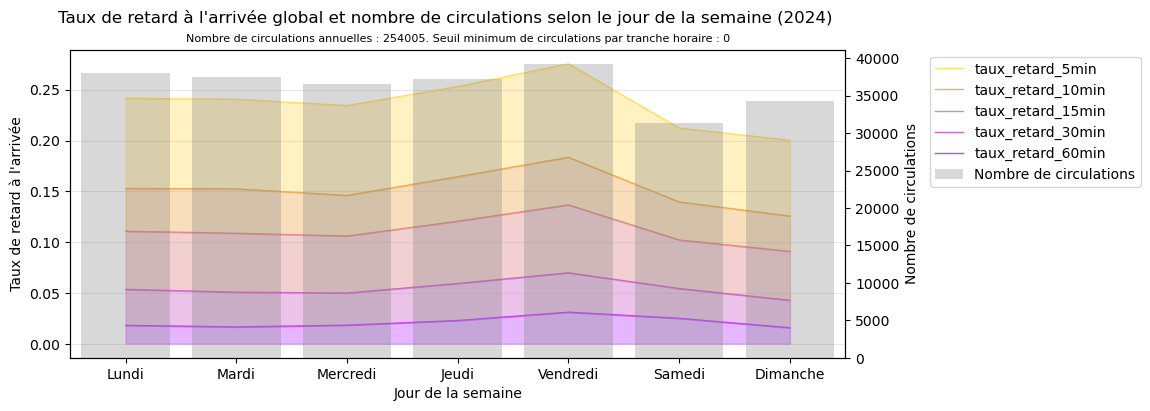

In [ ]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)

seuil_trajets_annuels_mini = 0

# Probabilité d'être en retard à l'arrivée selon le jour de la semaine
stats = df.groupby(["jour_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère le jour de la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Jour de la semaine")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : taux de retard plus élevé le vendredi, plus faible le weekend

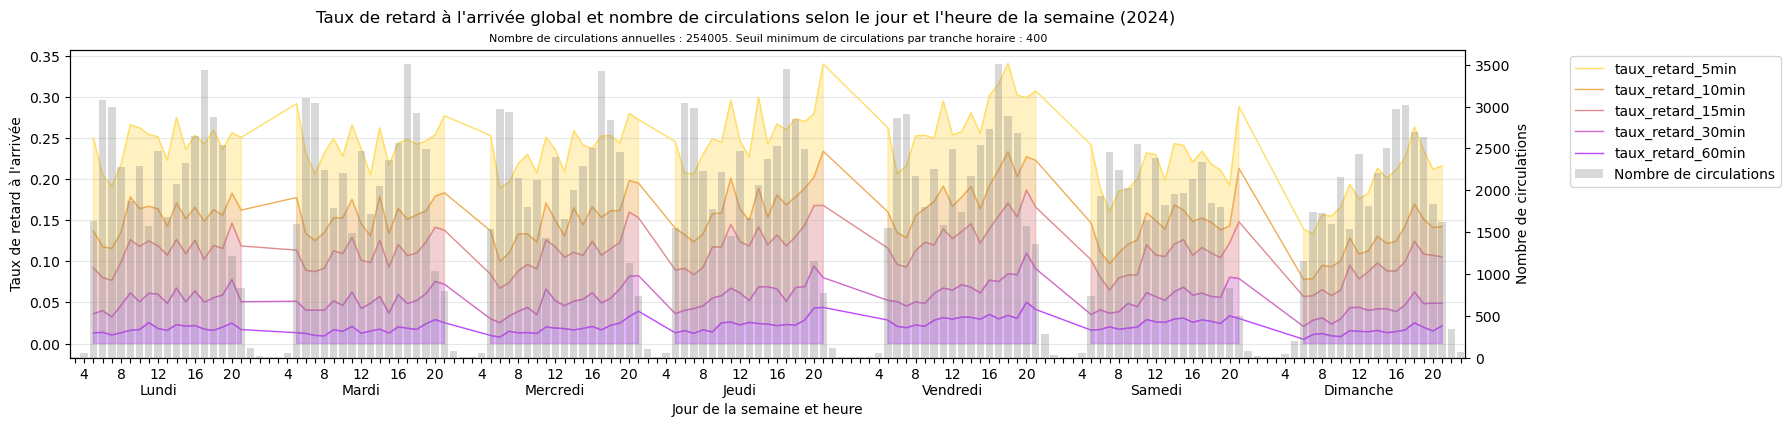

In [ ]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine ET l'heure de départ (2024)

seuil_trajets_annuels_mini = 400

# Probabilité d'être en retard à l'arrivée selon le jour et l'heure de la semaine 
stats = df.groupby(["jour_semaine", "heure_depart"]).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
stats = stats.reset_index(names=['jour_semaine','heure_depart'])

# quand le nb_circ < seuil, on va ici remplaver la valeur des taux de retard par NaN 
# (pour ne pas afficher les taux sur ces plages horaires, qui sont biaisés par le faible nombre de trajets)
stats.loc[stats["nb_circ"] < seuil_trajets_annuels_mini,
          ["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
           "taux_retard_30min", "taux_retard_60min"]] = np.nan

# Graphique
plt.figure(figsize=(18, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon le jour et l'heure de la semaine (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Jour de la semaine et heure")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min", 
                         "taux_retard_30min", "taux_retard_60min"]],
            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(range(len(stats)), stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Axe secondaire
ax2 = ax.twinx()
sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende unifiée
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.07, 1))

# Labels
heures_interet = [4, 8, 12, 16, 20]
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
x_labels = []
for ligne in stats.values:
    jour_num, heure = ligne[0], ligne[1]
    heure_label = f"{heure:.0f}" if heure in heures_interet else ""
    x_labels.append(f"{heure_label}\n{jours_semaine[int(jour_num)] if heure == 12 else ""}")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()


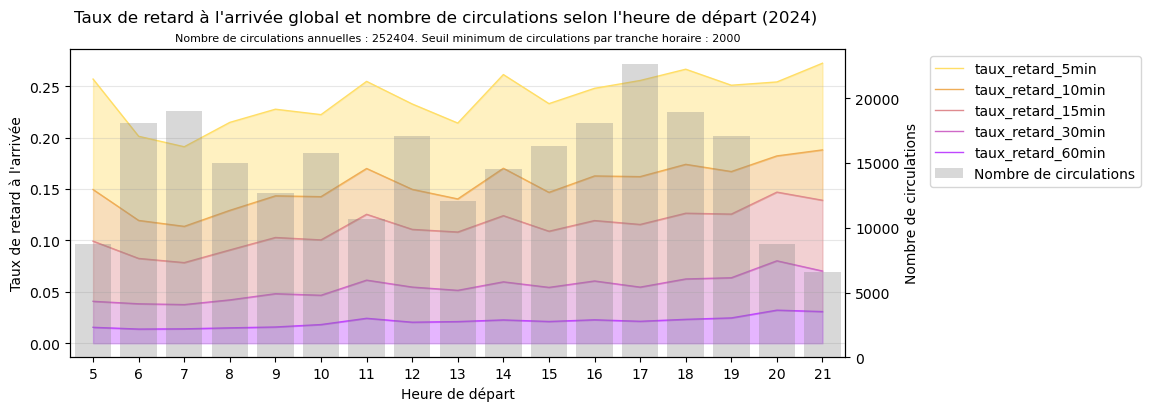

In [ ]:
### Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)

seuil_trajets_annuels_mini = 2000

# Probabilité d'être en retard à l'arrivée selon l'heure de départ 
stats = df.groupby(["heure_depart"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

# considère l'heure comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
plt.xlabel("Heure de départ")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# Constat : les trains du matin (6-8h) sont globalement plus ponctuels que les trains du soir (17-21h)

# Note qui explique peut-être la différence avec les réusltats présentés par Le Monde : je considère uniquement les terminus, pas les arrêts intermédiaires. 
# et je considère tous les trains SLO, y compris des trains qui ne sont pas des TAGV (même s'ils sont minoritaires dans la base de données)

In [ ]:
# Cas d'usages : taux de retard par heure selon la ville de départ et d'arrivée

def plot_retard_par_heure(depart, arrivée, seuil_trajets_annuels_mini=100):

    trajets_casdusage = df[(df["lib_ci_origine"].str.startswith(depart)) & (df["lib_ci_destination"].str.startswith(arrivée))]

    # Probabilité d'être en retard à l'arrivée selon l'heure de départ 
    stats = trajets_casdusage.groupby(["heure_depart"]).agg(
        retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
        retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
        taux_retard_5min = ('ret_arrivee_5min', 'mean'),
        taux_retard_10min = ('ret_arrivee_10min', 'mean'),
        taux_retard_15min = ('ret_arrivee_15min', 'mean'),
        taux_retard_30min = ('ret_arrivee_30min', 'mean'),
        taux_retard_60min = ('ret_arrivee_60min', 'mean'),
        nb_circ = ('id_circ', 'count')
    )

    # élimine les heures avec peu de circulations pour éviter le bruit
    stats = stats[stats["nb_circ"] > seuil_trajets_annuels_mini]

    # considère l'heure comme une chaine de caractères (pour l'affichage)
    stats.index = stats.index.astype(str)

    # Graphique :
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{depart} → {arrivée} : taux de retard à l'arrivée et nombre de circulations selon l'heure de départ (2024)")
    plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil_trajets_annuels_mini}", fontsize=8)
    plt.xlabel("Heure de départ")

    # Taux de retard
    ax = plt.gca()
    colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
    lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                        "taux_retard_30min", "taux_retard_60min"]], 
                            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
    ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
    ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
    ax.set_ylabel("Taux de retard à l'arrivée")
    ax.grid(axis='y', alpha=0.3)

    # Nombre de circulations
    ax2 = ax.twinx()
    barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
    ax2.set_ylabel("Nombre de circulations")

    # Légende
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

    plt.show()

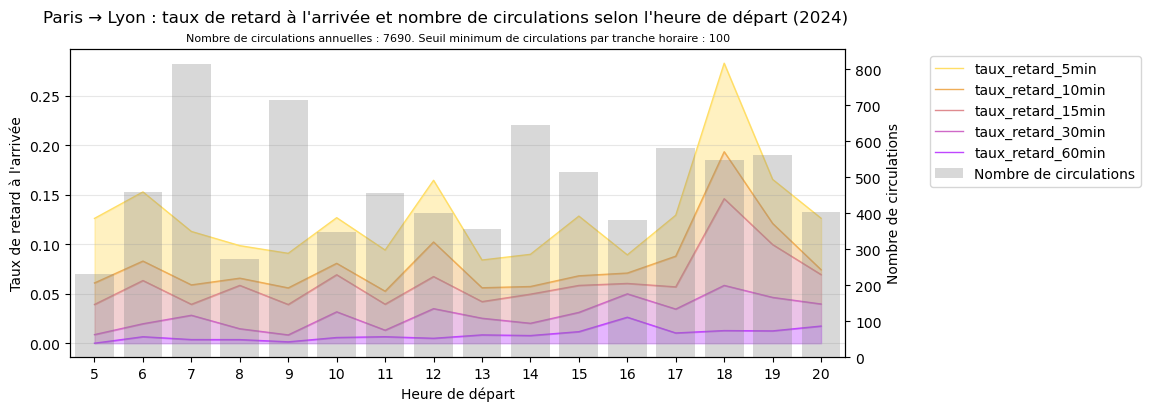

In [ ]:
plot_retard_par_heure('Paris', 'Lyon', seuil_trajets_annuels_mini=100)
# Remarque importante : on ne considère dans cette analyse que les terminus. Un train qui serait de passage à Lyon sans y terminer sa course ne sera pas pris en compte.

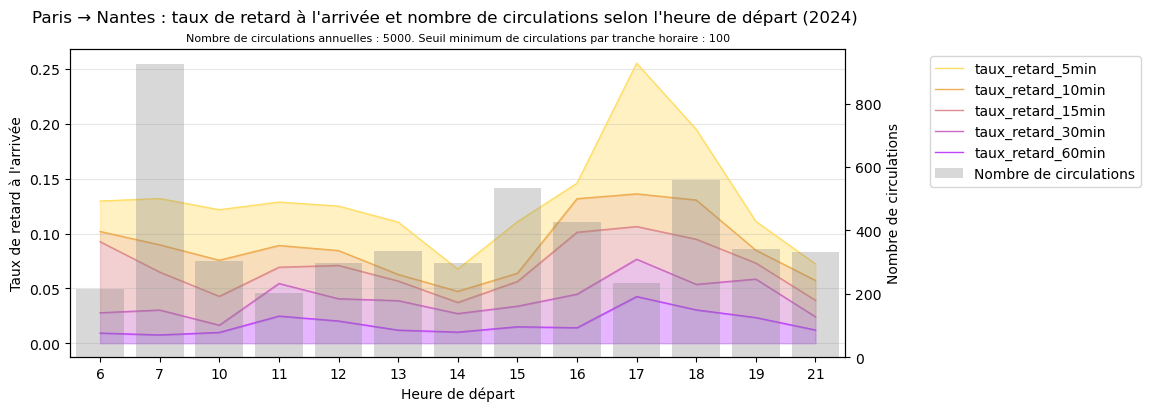

In [ ]:
plot_retard_par_heure('Paris', 'Nantes', seuil_trajets_annuels_mini=100)

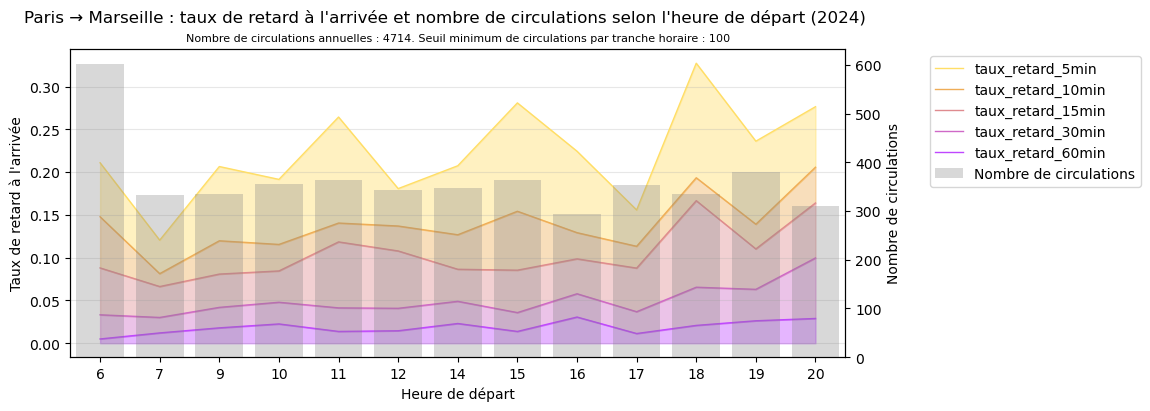

In [ ]:
plot_retard_par_heure('Paris', 'Marseille', seuil_trajets_annuels_mini=100)

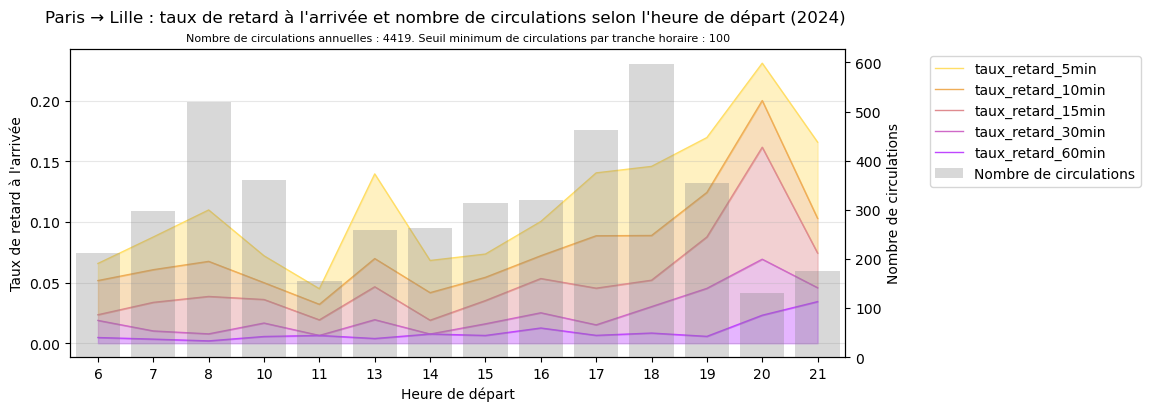

In [ ]:
plot_retard_par_heure('Paris', 'Lille', seuil_trajets_annuels_mini=100)

In [ ]:
# origines les plus fréquentes
df["lib_ci_origine"].value_counts().head(10)

lib_ci_origine
Paris-Gare-de-Lyon         33270
Paris-Montparnasse         26608
Paris-Nord                 18768
Paris-Est                  15217
Wannehain                  13588
Lyon-Perrache-Voyageurs    10175
Marseille-St-Charles        8921
Fréthun-Tunnel              8253
Nantes                      7637
Lille-Flandres              6898
Name: count, dtype: Int64

In [ ]:
# destinations les plus fréquentes
df["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Paris-Gare-de-Lyon         32805
Paris-Montparnasse         26759
Paris-Nord                 19262
Paris-Est                  15149
Wannehain                  13027
Marseille-St-Charles        9504
Lyon-Perrache-Voyageurs     9196
Fréthun-Tunnel              8377
Nantes                      7590
Lille-Flandres              6636
Name: count, dtype: Int64

In [ ]:
# liste des destinations les plus fréquentes, à partir d'une ville donnée
origine = "Paris"
df[df["lib_ci_origine"].str.startswith(origine)]["lib_ci_destination"].value_counts().head(10)

lib_ci_destination
Lyon-Perrache-Voyageurs    7167
Wannehain                  6767
Fréthun-Tunnel             5191
Nantes                     5106
Marseille-St-Charles       4830
Lille-Flandres             4461
Bordeaux-St-Jean           3311
Quimper                    3074
Pougny-Chancy              2648
La Rochelle-Ville          2641
Name: count, dtype: Int64

In [107]:
# Classement des trajets (num_marche) par taux de retard
retard_num_marche = df.groupby('num_marche').agg(
    lib_ci_origine = ('lib_ci_origine', 'first'),
    lib_ci_destination = ('lib_ci_destination', 'first'),
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_num_marche[retard_num_marche['nb_circ'] > 10].sort_values(by='taux_retard_60min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,num_marche,lib_ci_origine,lib_ci_destination,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
448,26986,Chambéry-Challes-les-Eaux,Paris-Gare-de-Lyon,47.758824,35.900000,0.764706,0.764706,0.764706,0.529412,0.294118,17
2277,9468,Stiring-Wendel,Paris-Est,37.400758,19.975000,0.647727,0.613636,0.568182,0.386364,0.250000,88
326,26560,Dax,Paris-Montparnasse,46.864583,23.650000,0.625000,0.562500,0.500000,0.500000,0.250000,16
308,26514,Bordeaux-St-Jean,Paris-Montparnasse,48.619444,31.025000,0.583333,0.583333,0.583333,0.583333,0.250000,12
2236,9362,Wannehain,Paris-Nord,35.692157,23.450000,0.764706,0.647059,0.647059,0.470588,0.235294,17
1110,64,Feignies,Paris-Nord,22.760256,0.750000,0.307692,0.307692,0.307692,0.230769,0.230769,13
394,26823,Lyon-Part-Dieu,Montpellier-St-Roch,45.680769,49.050000,1.000000,0.923077,0.923077,0.846154,0.230769,13
397,26830,Wannehain,Marne-la-Vallée-Chessy,29.679762,10.941667,0.785714,0.500000,0.428571,0.357143,0.214286,14
366,26702,Rennes,Paris-Montparnasse,30.992063,21.883333,0.714286,0.619048,0.571429,0.476190,0.190476,21
2458,9994,Strasbourg-Ville,Wannehain,24.980303,3.150000,0.363636,0.181818,0.181818,0.181818,0.181818,11


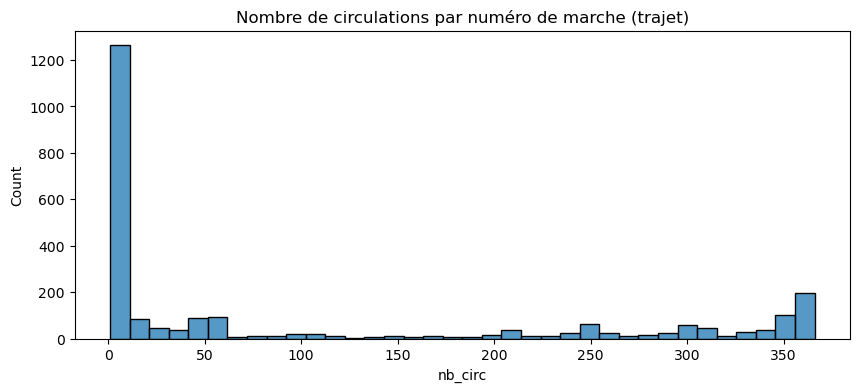

In [ ]:
plt.figure(figsize=(10, 4))
plt.title("Nombre de circulations par num_marche")
sns.histplot(data=retard_num_marche, x='nb_circ', binwidth=10)
plt.show()

In [108]:
# Deuxième approche : classement des trajets (en fonction du lib_ci_origine et lib_ci_destination) par taux de retard (ayant circulé au moins n fois sur l'année) 
# #TODO fitrer plutot sur le type de gare (A,B,C)
# en effet, certaines gares peuvent être reliées par plusieurs trajets (num_marche) différents

df_copy = df.copy()
df_copy['origine-destination'] = df_copy['lib_ci_origine'] + " → " + df_copy['lib_ci_destination']
retard_origine_destination = df_copy.groupby('origine-destination').agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_origine_destination[retard_origine_destination['nb_circ'] > 100].sort_values(by='taux_retard_60min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Nancy-Ville → Nice-Ville,20.330945,5.491667,0.524390,0.393293,0.341463,0.198171,0.091463,328
Arras → Paris-Nord,24.124812,4.900000,0.496241,0.398496,0.345865,0.233083,0.090226,133
Montpellier-St-Roch → Wannehain,21.657629,12.650000,0.653061,0.568513,0.431487,0.244898,0.081633,343
Marseille-St-Charles → Metz-Ville,17.241503,5.433333,0.500000,0.372549,0.294118,0.176471,0.078431,102
Valence-TGV → Marseille-St-Charles,16.750728,5.266667,0.519417,0.349515,0.271845,0.155340,0.067961,206
Nantes → Lille-Europe,12.612288,3.650000,0.398305,0.231638,0.172316,0.104520,0.062147,354
Lorient → Paris-Montparnasse,13.661497,4.366667,0.457143,0.310204,0.232653,0.142857,0.061224,245
Roissy-Aéroport-CDG 2 → Toulon,10.279190,0.108333,0.251429,0.211429,0.168571,0.120000,0.060000,350
Bordeaux-St-Jean → Tourcoing,12.897929,2.000000,0.431953,0.372781,0.269231,0.121302,0.059172,338


In [109]:
# trajets les plus en retard depuis Paris (ayant circulé au moins 100 fois sur l'année) #TODO fitrer plutot sur le type de gare (A,B,C)
stats = retard_origine_destination
stats[stats.index.str.startswith("Paris") & (stats['nb_circ'] > 100)].sort_values(by='taux_retard_60min', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Paris-Gare-de-Lyon → Toulon,9.300203,0.758333,0.289634,0.198171,0.149390,0.079268,0.045732,328
Paris-Gare-de-Lyon → Nice-Ville,13.103469,3.266667,0.410819,0.279890,0.212858,0.117993,0.045080,2551
Paris-Gare-de-Lyon → Lyon-Part-Dieu,7.250431,0.000000,0.174950,0.137177,0.123260,0.093439,0.041750,503
Paris-Montparnasse → St-Nazaire,9.439063,0.500000,0.265625,0.193750,0.162500,0.087500,0.040625,320
Paris-Montparnasse → Toulouse-Matabiau,6.726999,-0.900000,0.241179,0.172398,0.139795,0.085753,0.037070,2239
Paris-Est → Thionville,7.064634,1.466667,0.211382,0.113821,0.081301,0.048780,0.032520,123
Paris-Gare-de-Lyon → Perpignan,6.295083,-0.066667,0.267824,0.189962,0.139306,0.063790,0.025797,2132
Paris-Austerlitz → Nantes,4.764537,-1.083333,0.158889,0.123333,0.100000,0.067778,0.025556,900
Paris-Montparnasse → Hendaye,5.259538,-1.000000,0.186996,0.132187,0.108544,0.054272,0.025255,1861


In [110]:
# trajets les plus fréquents depuis Paris
stats = retard_origine_destination
stats[stats.index.str.startswith("Paris")].sort_values(by='nb_circ', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Paris-Gare-de-Lyon → Lyon-Perrache-Voyageurs,2.961741,0.100000,0.127128,0.077611,0.058031,0.024688,0.006527,7048
Paris-Nord → Wannehain,6.010399,0.966667,0.199793,0.142604,0.114674,0.060588,0.022019,6767
Paris-Nord → Fréthun-Tunnel,5.438666,0.033333,0.206126,0.160085,0.128492,0.072048,0.023310,5191
Paris-Gare-de-Lyon → Marseille-St-Charles,6.145403,1.183333,0.222820,0.142058,0.106026,0.051149,0.019466,4829
Paris-Nord → Lille-Flandres,2.479134,-0.033333,0.114997,0.076440,0.049092,0.021744,0.008294,4461
Paris-Montparnasse → Nantes,3.929936,-0.500000,0.135638,0.092253,0.072706,0.039571,0.017878,4195
Paris-Montparnasse → Bordeaux-St-Jean,6.037269,1.233333,0.262776,0.151497,0.102812,0.047777,0.022074,3307
Paris-Montparnasse → Quimper,5.439775,0.000000,0.196679,0.139694,0.109085,0.057636,0.021817,3071
Paris-Gare-de-Lyon → Pougny-Chancy,7.388904,1.541667,0.242069,0.174471,0.137840,0.057402,0.016616,2648


In [111]:
# trajets les plus fréquents
retard_origine_destination.sort_values(by='nb_circ', ascending=False).head(10).style.background_gradient(cmap='coolwarm')

,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
origine-destination,,,,,,,,
Lyon-Perrache-Voyageurs → Paris-Gare-de-Lyon,3.652288,0.683333,0.166467,0.098840,0.071228,0.031613,0.008670,7497
Wannehain → Paris-Nord,12.502261,4.333333,0.477188,0.355341,0.269469,0.124742,0.037767,7255
Paris-Gare-de-Lyon → Lyon-Perrache-Voyageurs,2.961741,0.100000,0.127128,0.077611,0.058031,0.024688,0.006527,7048
Paris-Nord → Wannehain,6.010399,0.966667,0.199793,0.142604,0.114674,0.060588,0.022019,6767
Paris-Nord → Fréthun-Tunnel,5.438666,0.033333,0.206126,0.160085,0.128492,0.072048,0.023310,5191
Fréthun-Tunnel → Paris-Nord,6.013017,1.516667,0.284213,0.182792,0.121666,0.057037,0.020635,5137
Paris-Gare-de-Lyon → Marseille-St-Charles,6.145403,1.183333,0.222820,0.142058,0.106026,0.051149,0.019466,4829
Paris-Nord → Lille-Flandres,2.479134,-0.033333,0.114997,0.076440,0.049092,0.021744,0.008294,4461
Lille-Flandres → Paris-Nord,3.452256,1.033333,0.153618,0.074412,0.051815,0.021913,0.007761,4381


In [42]:
#plt.figure(figsize=(10, 4))
#plt.title("Nombre de circulations par origine-destination")
#sns.histplot(data=retard_origine_destination, x='nb_circ')
#plt.show()

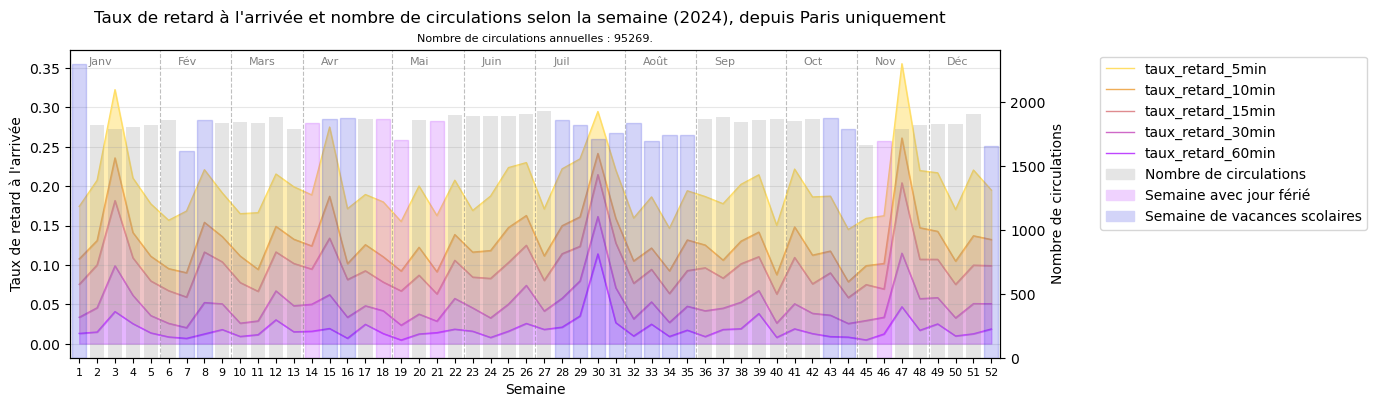

In [ ]:
# Impact des vacances scolaires (et jours féries, ponts) sur le taux de retard ?

# Analyser par semaine. Les semaines de vacances seront identifiées pour observer leur effet sur les retards.
# Objectif : graphique du taux de retard (5,10,15,30,60 minutes) par semaine, en précisant lesquelles sont des vacances.

# Restreindre l'analyse au cas de Paris. Trajets vers et depuis Paris uniquement. 

semaines = np.arange(1, 53)
semaines_vacances_paris_2024 = [1, 7, 8, 15, 16, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 52] # numéros de semaine des vacances scolaires

jours_feries = pd.read_csv("../data/1-raw/jours_feries_metropole.csv", dtype={"annee": int, "nom_jour_ferie": str}, parse_dates=['date'])
jours_feries_2024 = jours_feries[jours_feries["annee"] == 2024].copy()
jours_feries_2024["week"] = jours_feries_2024["date"].dt.isocalendar().week
jours_feries_2024["day_of_week"] = jours_feries_2024["date"].dt.dayofweek # TODO : retirer les jours fériés qui arrivent le weekend ?
jours_feries_par_semaine = jours_feries_2024.groupby("week").size()

semaine_info = []
for semaine in semaines:
    nb_jours_feries = int(jours_feries_par_semaine.get(semaine, 0))
    is_vacances = semaine in semaines_vacances_paris_2024
    semaine_info.append({
        "num_semaine": semaine,
        "nb_jours_feries": nb_jours_feries,
        "is_vacances": is_vacances
    })
semaine_info_df = pd.DataFrame(semaine_info)

# Trajets depuis Paris uniquement
trajets_depuis_paris = df[(df['lib_ci_origine'].str.startswith('Paris'))]

# Taux de retard à l'arrivée selon la semaine
stats = trajets_depuis_paris.groupby(["num_semaine"]).agg(
    retard_arrivee_moyen = ('ret_arrivee_obs_min', 'mean'),
    retard_arrivee_median = ('ret_arrivee_obs_min', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# considère la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(12, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la semaine (2024), depuis Paris uniquement")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}.", fontsize=8)
plt.xlabel("Semaine")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.5)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.2, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# pour chaque semaine avec des jours fériés, change la couleur du barplot
for semaine in semaine_info_df[semaine_info_df["nb_jours_feries"] > 0]["num_semaine"]:
    if str(semaine) in stats.index:
        barplot.patches[stats.index.get_loc(str(semaine))].set_color("#B01EFE")

# pour chaque semaine de vacances, change la couleur du barplot
for semaine in semaine_info_df[semaine_info_df["is_vacances"]]["num_semaine"]:
    if str(semaine) in stats.index:
        barplot.patches[stats.index.get_loc(str(semaine))].set_color("#232ADD")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
import matplotlib.patches as mpatches
nombre_de_circulations_patch = mpatches.Patch(color="#e5e5e5", label="Nombre de circulations")
handles2 = [nombre_de_circulations_patch]
ferie_patch = mpatches.Patch(color="#efd2fe", label="Semaine avec jour férié")
vacances_patch = mpatches.Patch(color="#d3d4f8", label="Semaine de vacances scolaires")
ax.legend(handles1 + handles2 + [ferie_patch, vacances_patch], labels1 + labels2 + ["Semaine avec jour férié", "Semaine de vacances scolaires"], loc="upper left", bbox_to_anchor=(1.1, 1))

# pour chaque mois, ajoute une barre verticale pour séparer les semaines
mois_separateurs = [1, 6, 10, 14, 19, 23, 27, 32, 36, 41, 45, 49]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.axvline(x=stats.index.get_loc(str(sep))-0.5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
# ajoute un label pour chaque mois, en haut du graphique, juste à droite de la barre verticale
mois_labels = ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sep", "Oct", "Nov", "Déc"]
for sep in mois_separateurs:
    if str(sep) in stats.index:
        ax.text(stats.index.get_loc(str(sep))+0.5, ax.get_ylim()[1]*0.95, mois_labels[mois_separateurs.index(sep)], fontsize=8, color='gray')

# Labels axe x (numéros de semaines)
ax.set_xticks(range(len(stats.index)))
ax.set_xticklabels(stats.index, fontsize=8)

plt.show()

# constat : quelques corrélations (vacances d'hiver, printemps, été) avec augmentation du taux de retard, mais pas systématique